In [2]:
from IPython.display import clear_output
!pip install paddle-quantum
!pip install qiskit
# !pip install qiskit-experiments
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls

gdrive	sample_data


In [ ]:
%cd gdrive/My Drive/qiskit-dynamics-backend_tutorial

/content/gdrive/My Drive/qiskit-dynamics-backend_tutorial


In [ ]:
!git clone https://github.com/DanPuzzuoli/qiskit-dynamics.git

fatal: destination path 'qiskit-dynamics' already exists and is not an empty directory.


In [ ]:
!git switch backend_tutorial

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!python setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [3]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
!pip install multiset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import qiskit
import numpy as np
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit import pulse, QuantumCircuit,circuit,transpile
from qiskit.circuit import Gate
from qiskit.pulse import library, Schedule,GaussianSquare, ControlChannel, Play, Drag,DriveChannel,Delay,DriveChannel, SymbolicPulse, ShiftPhase
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule,remove_directives
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization.pulse_v2 import draw, IQXSimple,IQXDebugging
from qiskit.compiler import assemble, schedule
from qiskit import IBMQ

In [5]:
from qiskit.providers.fake_provider.backends.athens.fake_athens import FakeAthens
import copy
import qiskit
# import multiset
from qiskit.circuit.parameterexpression import ParameterValueType
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import pulse, QuantumCircuit, IBMQ, visualization,execute, Aer
from qiskit.pulse import library
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.visualization.pulse_v2 import draw
from qiskit.providers.fake_provider import FakeQuito, FakeBelem, FakeSantiago, FakeManila, FakeLagos, FakeLima,FakeJakarta, FakeAthens
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.pulse.instructions import Instruction
from qiskit.compiler import assemble, schedule
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.providers.aer import PulseSimulator
# from qiskit_dynamics import Solver, DynamicsBackend

In [6]:
backend = FakeQuito()

In [ ]:
backend_run = DynamicsBackend.from_backend(backend)


NameError: ignored

In [ ]:
mmap = backend.configuration().meas_map
print(mmap)

[[0, 1, 2, 3, 4]]


In [ ]:
red_map = meas_map(mmap).reduce(mapping=[0,1])

NameError: ignored

In [7]:
backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2 }
backend_model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator(system_model=backend_model)
backend_config = backend.configuration().to_dict()
num_qubits = int(backend_config['n_qubits'])
f = backend.properties().frequency
freq = [f(i) for i in range(num_qubits)]

<ipython-input-7-d32ebac5a4ad>:3: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backend_sim = PulseSimulator(system_model=backend_model)


In [ ]:
backend

/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


<FakeQuito('fake_quito')>

# 1. Prepare Pulses


## 1.1 CR




In [ ]:
def generate_2q_pulsewithmeasure(backend, amp, angle):
  qubits = (0,1)
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  angle_parameter = angle
  duration_parameter = cr_pulse.parameters['duration']
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = cr_pulse.parameters['width']
  #declare pulse parameters and build GaussianSquare pulse
  cr_params = {}
  cr_params['duration'] = duration_parameter
  cr_params['amp'] = amp
  cr_params['angle'] = angle_parameter
  cr_params['sigma'] = sigma_parameter
  cr_params['width'] = width_parameter
  with pulse.build(backend) as pulse_x:
    pulse.play(GaussianSquare(**cr_params), ControlChannel(0))
    pulse.barrier(0)
    pulse.measure(qubits)

  return block_to_schedule(pulse_x)

In [ ]:
twoqpulse = generate_2q_pulsewithmeasure(backend, 0.1,0.1)

In [ ]:
print(twoqpulse)

Schedule((0, Play(GaussianSquare(duration=368, sigma=64, width=112, amp=0.1, angle=0.1), ControlChannel(0))), (368, RelativeBarrier(ControlChannel(1), DriveChannel(0), MeasureChannel(0), AcquireChannel(0), ControlChannel(0))), (368, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (368, Acquire(22400, AcquireChannel(1), MemorySlot(1))), (368, Play(GaussianSquare(duration=22400, sigma=64, width=22144, amp=0.034, angle=0.5605318066844013, name='gaussian_square_d01b'), MeasureChannel(0), name='gaussian_square_d01b')), (368, Play(GaussianSquare(duration=22400, sigma=64, width=22144, amp=0.051, angle=-1.2712280855270208, name='gaussian_square_3048'), MeasureChannel(1), name='gaussian_square_3048')), (22768, TimeBlockade(1680, AcquireChannel(0))), (22768, TimeBlockade(1680, AcquireChannel(1))), (22768, Delay(1680, MeasureChannel(0))), (22768, Delay(1680, MeasureChannel(1))), name="block1759")


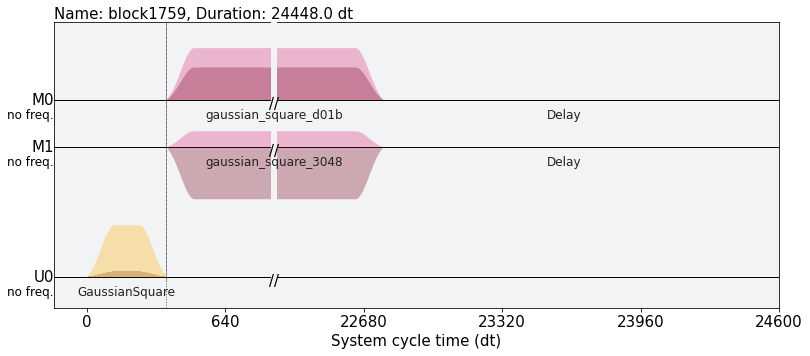

In [ ]:
twoqpulse.draw()

## 1.2 Minimal basis CR+1q

In [ ]:
def generate_2q_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  angle_parameter = angle
  duration_parameter = cr_pulse.parameters['duration']
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = cr_pulse.parameters['width']
  #declare pulse parameters and build GaussianSquare pulse
  cr_params = {}
  cr_params['duration'] = duration_parameter
  cr_params['amp'] = amp
  cr_params['angle'] = angle_parameter
  cr_params['sigma'] = sigma_parameter
  cr_params['width'] = width_parameter
  with pulse.build(backend) as pulse_x:
    pulse.play(GaussianSquare(**cr_params), ControlChannel(0))

  return block_to_schedule(pulse_x)

In [ ]:
def generate_parametric_pulse1q(backend, q1, amp_list, angle_list):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  sched1 = pulse.Play(Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp_list, angle=angle_list), DriveChannel(0))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  pulse_x.append(sched1)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      pulse.barrier(q1)

  return  block_to_schedule(pulse_y)

In [ ]:
def generate_12q_pulse(backend, oneqpulse, twoqpulse, qubits):
  oneqpulse+=(copy.deepcopy(twoqpulse))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      pulse.call(oneqpulse)
      pulse.barrier(0,1)
      pulse.measure(qubits)

  return block_to_schedule(pulse_x)


In [ ]:
qubits = (0,1)
oneqpulse = generate_parametric_pulse1q(backend, 0, 0.1, 0.1)
twoqpulse = generate_2q_pulse(backend, 0.1,0.1)
pulse_onetwo = generate_12q_pulse(backend, oneqpulse, twoqpulse, qubits)

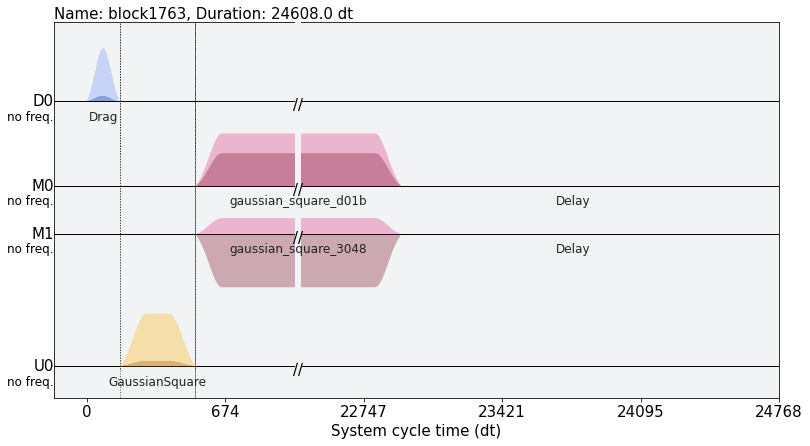

In [ ]:
pulse_onetwo.draw()

In [ ]:
def generate_2q_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  angle_parameter = angle
  duration_parameter = cr_pulse.parameters['duration']
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = cr_pulse.parameters['width']
  #declare pulse parameters and build GaussianSquare pulse
  cr_params = {}
  cr_params['duration'] = duration_parameter
  cr_params['amp'] = amp
  cr_params['angle'] = angle_parameter
  cr_params['sigma'] = sigma_parameter
  cr_params['width'] = width_parameter
  with pulse.build(backend) as pulse_x:
    pulse.play(GaussianSquare(**cr_params), ControlChannel(0))
    pulse.barrier(0,1)

  return block_to_schedule(pulse_x)

In [ ]:
def generate_parametric_pulse1q(backend, q1, amp_list, angle_list):
  sched1 = pulse.Play(Drag(duration=160, sigma=40, beta=0.4469017066717889, amp=amp_list, angle=angle_list), DriveChannel(0))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  pulse_x.append(sched1)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)

  return  block_to_schedule(pulse_y)

In [ ]:
def generate_12q_pulse(backend, oneqpulse, twoqpulse, qubits):
  oneqpulse+=(copy.deepcopy(twoqpulse))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      pulse.call(oneqpulse)
      pulse.barrier(0,1)

  return block_to_schedule(pulse_x)

In [ ]:
def generate_dressed_cr_pulse(backend, oneqpulse_left,oneqpulse_right, twopulse, qubits):
  qubits = (0,1)
  oneqpulse_left +=(copy.deepcopy(twoqpulse))
  oneqpulse_left += (copy.deepcopy(oneqpulse_right))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      pulse.call(oneqpulse_left)
      pulse.barrier(0,1)
      pulse.measure(qubits)

  return block_to_schedule(pulse_x)

In [ ]:
oneqpulse_left = generate_parametric_pulse1q(backend, 0, 0.1, 0.1)
oneqpulse_right = generate_parametric_pulse1q(backend, 0, 0.1, 0.1)
qubits = (0,1)
twoqpulse = generate_2q_pulse(backend, 0.1,0.1)
pulse_twoone = generate_dressed_cr_pulse(backend, oneqpulse_left, oneqpulse_right, twoqpulse, qubits)

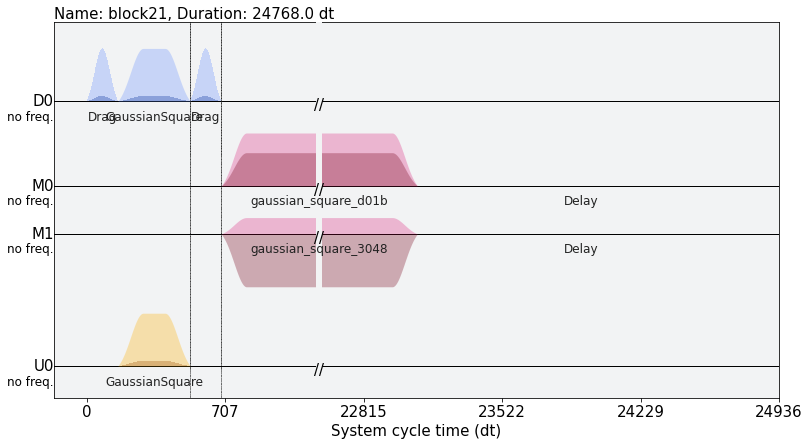

In [ ]:
pulse_twoone.draw()

In [ ]:
def generate_2q_pulse(backend, amp, angle, width_time, qbit):
  width = 16*width_time
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  int(width + 2 * cr_risefall * cr_params['sigma'])
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = width
  #declare pulse parameters and build GaussianSquare pulse
  #with pulse.build(backend) as pulse_x:
  with pulse.build(backend) as pulse_x:
    pulse.play(GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter), ControlChannel(qbit))
    pulse.play(GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter), DriveChannel(qbit))
    pulse.barrier(0,1)

  return block_to_schedule(pulse_x)

In [ ]:
pulse_twoq1, pulse_twoq2 = generate_2q_pulse(backend, 2, amp[2], angle[2])

NameError: ignored

In [ ]:
def generate_2qpulselayer(backend, qbit, amp, angle, width):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(qbit):
    pulse_twoq1, pulse_twoq2 = generate_2q_pulse(backend, amp[qubit], angle[qubit], width[qubit], qubit)
    pulse_x.append(pulse_twoq1)
    pulse_x.append(pulse_twoq2)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0,1]): 
      pulse.call(pulse_x)
      for qubit in range(qbit):
        pulse.barrier(qubit)
  return pulse_y

In [ ]:
twoqpulse = generate_2qpulselayer(backend, 4, amp, angle)

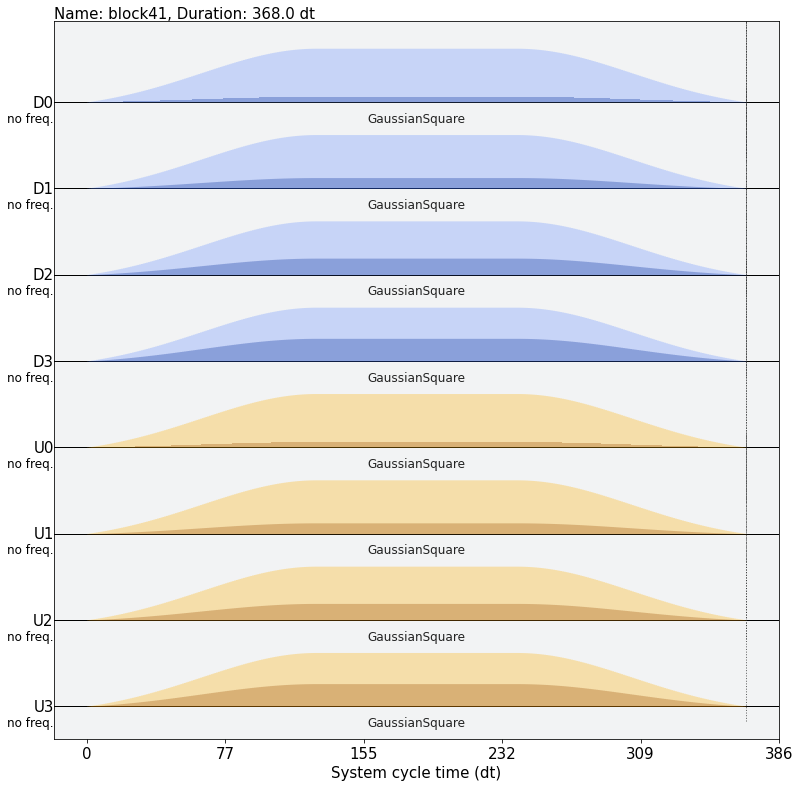

In [ ]:
twoqpulse.draw()

In [ ]:

def generate_parametric_pulse1q(backend, q1, amp_list, angle_list):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  sched1 = pulse.Play(Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp_list, angle=angle_list), DriveChannel(q1))
  sched2 = pulse.Play(Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp_list, angle=angle_list), DriveChannel(q1+1))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  pulse_x.append(sched1)
  pulse_x.append(sched2)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      pulse.barrier(q1)
  return  block_to_schedule(pulse_y)

In [ ]:
def generate_1qpulse_layer(backend, qbit, amp, angle):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(qbit):
    pulse_oneq = generate_parametric_pulse1q(backend, qubit, amp[qubit], angle[qubit])
    pulse_x.append(pulse_oneq)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      for qubit in range(qbit):
        pulse.barrier(qubit)
  return pulse_y


In [ ]:
def generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits):
  oneqpulse+=(copy.deepcopy(twoqpulse))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      pulse.call(oneqpulse)
      pulse.barrier(0,1)
      pulse.measure(qubits)

  return block_to_schedule(pulse_x)

In [ ]:
qubits = (0,1)
oneqpulse = generate_parametric_pulse1q(backend, 0, 0.1, 0.1)
twoqpulse = generate_2q_pulse(backend, 0.1,0.1,2,0)
pulse_onetwo1d1r = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

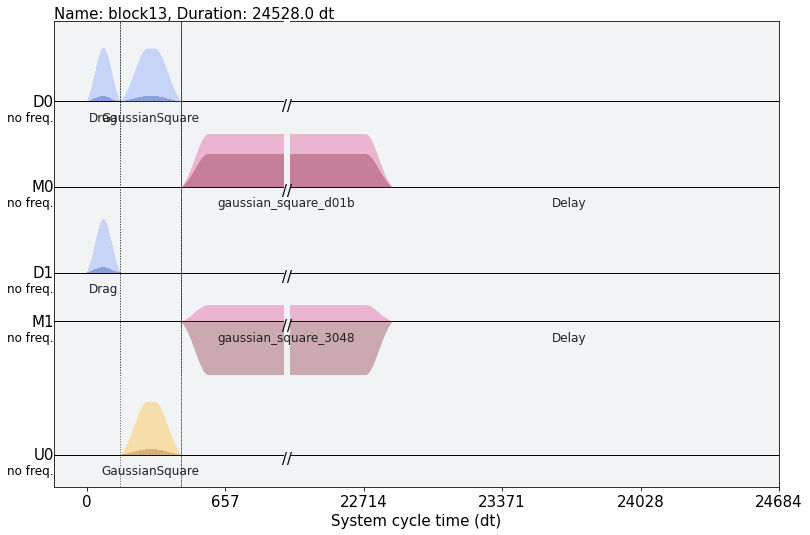

In [ ]:
pulse_onetwo1d1r.draw()

In [ ]:
backend = FakeQuito()

In [ ]:
amp = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
angle = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

In [ ]:
oneqpulse = generate_1qpulse_layer(backend, 4, amp, angle)

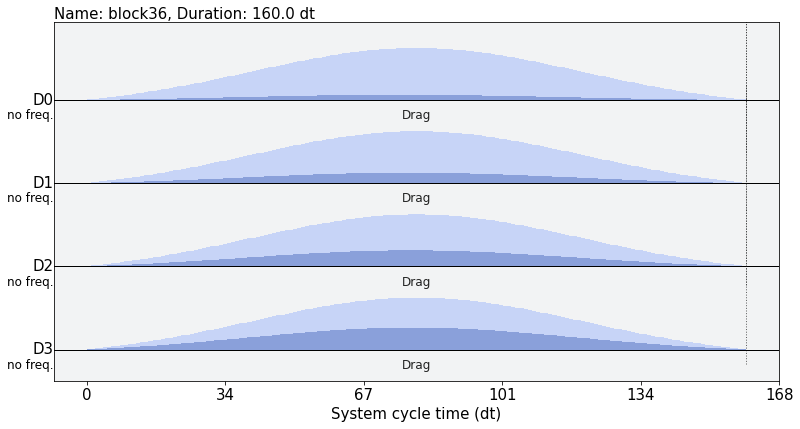

In [ ]:
oneqpulse.draw()

In [ ]:
def generate_firstlayer(backend, num_qubits, amp, angle, width_time):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(num_qubits):
    pulse_oneq = generate_parametric_pulse1q(backend, qubit, amp[qubit], angle[qubit])
    pulse_x.append(pulse_oneq)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      for qubit in range(num_qubits):
        pulse.barrier(qubit)
  for qubit in range(num_qubits):
    pulse_twoq1, pulse_twoq2 = generate_2q_pulse(backend, amp[qubit:][qubit], angle[qubit:][qubit], width_time[qubit],qubit)
    pulse_y.append(pulse_twoq1)
    pulse_y.append(pulse_twoq2)
  with pulse.build(backend) as pulse_z:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_y)
      for qubit in range(num_qubits):
        pulse.barrier(qubit)
  return pulse_z


In [ ]:
firstlayer = generate_firstlayer(backend, 4, amp, angle)

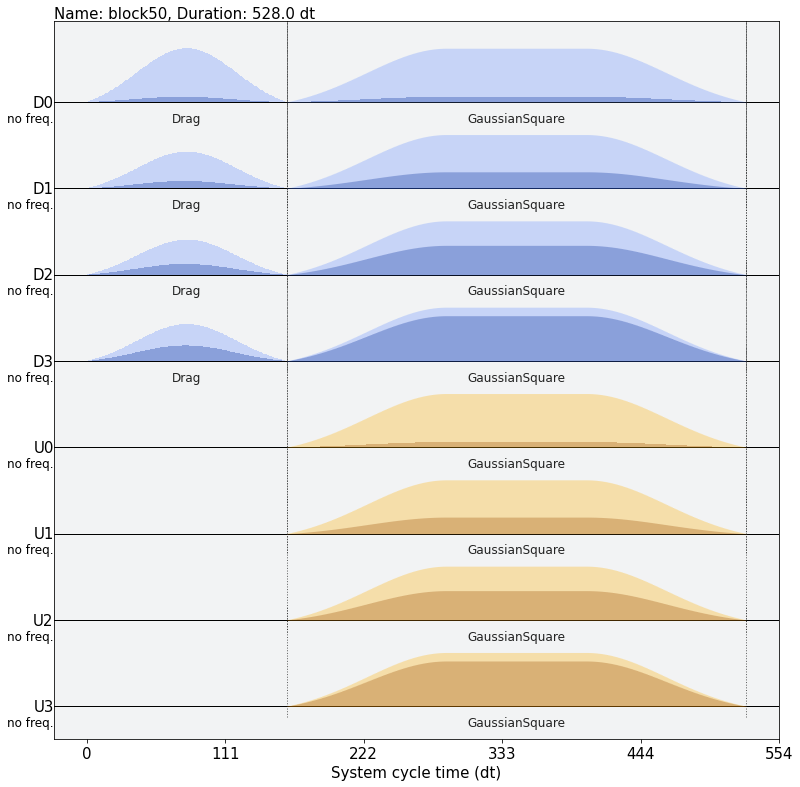

In [ ]:
firstlayer.draw()

In [ ]:
def generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits):
  oneqpulse+=(copy.deepcopy(twoqpulse))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      pulse.call(oneqpulse)
      pulse.barrier(0,1)
      pulse.measure(qubits)

  return block_to_schedule(pulse_x)

In [ ]:
qubits = (0,1)
oneqpulse = generate_parametric_pulse1q(backend, 1, 0.1, 0.1)
twoqpulse = generate_2q_pulse(backend, 0.1,0.1)
pulse_onetwo1d1r = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

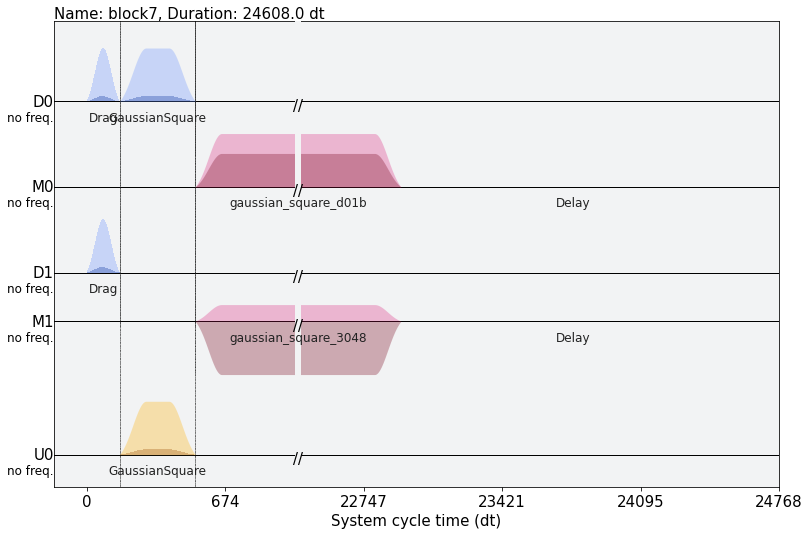

In [ ]:
pulse_onetwo1d1r.draw()

## 1.3 dressed CR(under construction)

In [8]:
def generate_2q_pulse(backend, amp, angle, duration_time, qbit):
  duration = duration_time
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  duration
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
  #declare pulse parameters and build GaussianSquare pulse
  sched1 = pulse.Play(GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter), ControlChannel(qbit))

  with pulse.build(backend) as pulse_x:
    sched = Schedule()
  pulse_x.append(sched1)
  with pulse.build(backend) as pulse_y:
    pulse.call(pulse_x)
    pulse.barrier(qbit)
  #sched1= pulse.Play(GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter), DriveChannel(qbit))
  #pulse.barrier(0,1)

  return pulse_y

In [9]:
def generate_2qpulselayer(backend, qbit, amp, angle, width):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0,1]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(qbit):
    pulse_twoq1 = generate_2q_pulse(backend, amp[qubit], angle[qubit], width[qubit], qubit)
    pulse_x.append(pulse_twoq1)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0,1]): 
      pulse.call(pulse_x)
      for qubit in range(qbit):
        pulse.barrier(qubit)
  return pulse_y

In [10]:
def generate_1q2pulse_layer(backend, qbit, amp, angle):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(qbit):
    pulse_oneq = generate_parametric_pulse1q(backend, qubit, amp[qubit], angle[qubit])
    pulse_x.append(pulse_oneq)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      for qubit in range(qbit):
        pulse.barrier(qubit)
  return pulse_y


In [11]:
def generate_parametric_pulse1q(backend, qbit, amp_list, angle_list):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  # with pulse.build(backend) as pulse_x:
  #   with pulse.transpiler_settings(initial_layout= [0]):
  #     sched = Schedule()
  #     pulse.call(sched)
  sched1 = pulse.Play(Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp_list, angle=angle_list), DriveChannel(qbit))
  # pulse_x.append(sched1)
  # with pulse.build(backend) as pulse_y:
  #   with pulse.transpiler_settings(initial_layout= [0]): 
  #     pulse.call(pulse_x)

  return  sched1

In [12]:
def generate_secondlayer(backend, num_qubits, amp, angle, width_time):
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  for qubit in range(num_qubits):
    pulse_oneq = generate_parametric_pulse1q(backend, qubit, amp[qubit], angle[qubit])
    pulse_x.append(pulse_oneq)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      for qubit in range(num_qubits):
        pulse.barrier(qubit)
  pulse_twoq1 = generate_2q_pulse(backend, amp[num_qubits:num_qubits+1][num_qubits-2], angle[num_qubits:num_qubits+1][num_qubits-2],width_time[num_qubits-2], num_qubits-1)
  pulse_y+=pulse_twoq1
  with pulse.build(backend) as pulse_y1:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_y)
      for qubit in range(num_qubits):
        pulse.barrier(qubit)
  for qubit in range(num_qubits):
    pulse_oneq = generate_parametric_pulse1q(backend, qubit, amp[num_qubits+1:][qubit], angle[num_qubits+1:][qubit])
    pulse_y1.append(pulse_oneq)
  with pulse.build(backend) as pulse_z:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_y1)
      for qubit in range(num_qubits):
        pulse.barrier(qubit)
        pulse.measure(qubit)
  return pulse_z

# 2. Sampling

## 2.1 Test

In [13]:
import qiskit.quantum_info as qi

In [ ]:
import qiskit.quantum_info as qi

twoqpulse = generate_2q_pulse(backend, 0.5, np.pi/2)
twoqpulse.draw()

TypeError: ignored

In [42]:
amp = [0.1,0.2,0.3, 0.1,0.1]
angle = [0.1,0.2,0.3,0.2,0.5]
duration = [320]

In [53]:
firstlayer = generate_secondlayer(backend, 2, amp, angle,duration)

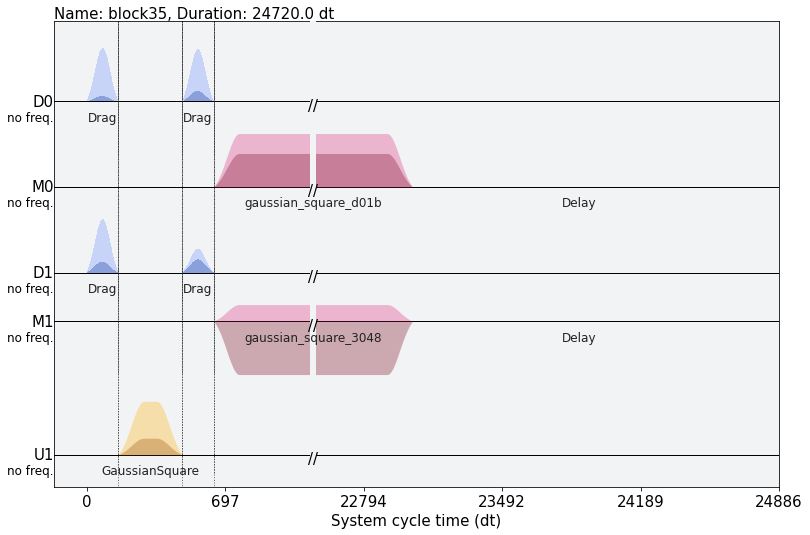

In [54]:
firstlayer.draw()

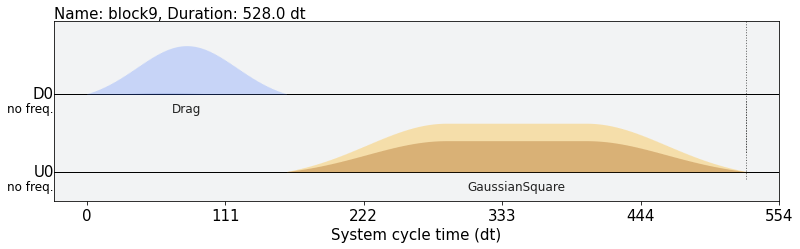

In [ ]:
qubits = (0,1)
oneqpulse = generate_parametric_pulse1q(backend, 0, amp, angle)
twoqpulse = generate_2q_pulse(backend, 0.1,0.1,2,0)
pulse_onetwo1d1r = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

In [ ]:
IBMQ.save_account('c7a71bc4b2858304571d35eb5e371e449e5c346110b36c744f51b65388d4ac1b7468740d58d6fcd44967b2080d02af986cc22f2406a84813bbabd9ff5bf06315', overwrite=True)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(
    hub="ibm-q-ornl", group="ornl", project="csc509"
)
backend = provider.get_backend('ibmq_quito')

<ipython-input-45-835f15ce7032>:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('c7a71bc4b2858304571d35eb5e371e449e5c346110b36c744f51b65388d4ac1b7468740d58d6fcd44967b2080d02af986cc22f2406a84813bbabd9ff5bf06315', overwrite=True)


In [ ]:
with pulse.build(backend) as pulse_x:
  circ = QuantumCircuit(2)
  circ.x(0)
  circ.cx(0,1)
  circ.measure_all()
  pulse.call(circ)


In [ ]:
print(pulse_x)

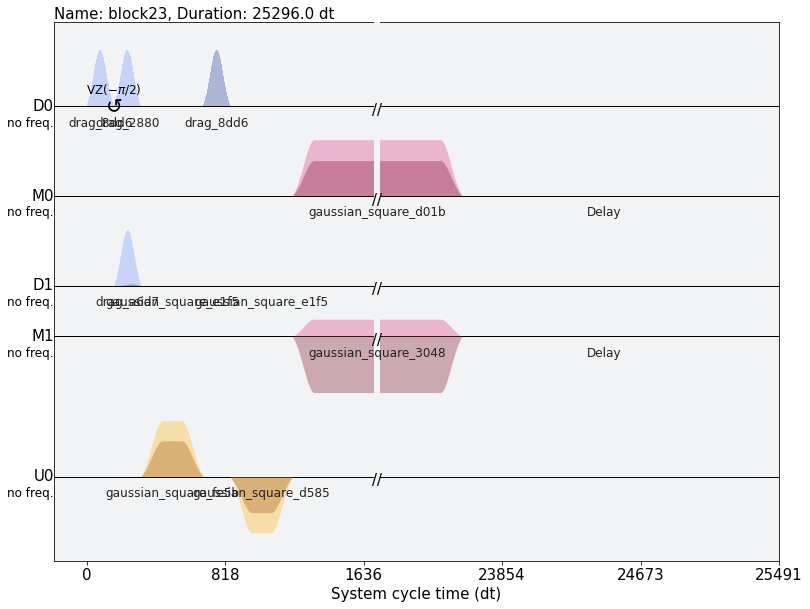

In [ ]:
pulse_x.draw()

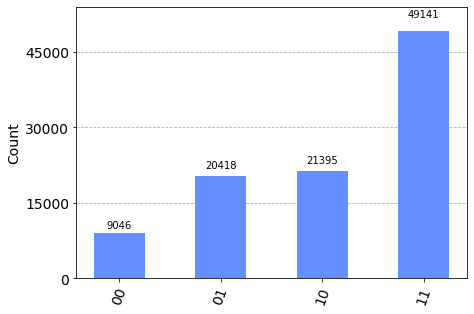

In [55]:
shots = 100000
cirq_gates = assemble(firstlayer,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=shots)

sim_result = backend_sim.run(cirq_gates).result()
from qiskit.visualization import plot_histogram
pulse_counts = sim_result.get_counts()
plot_histogram(pulse_counts)

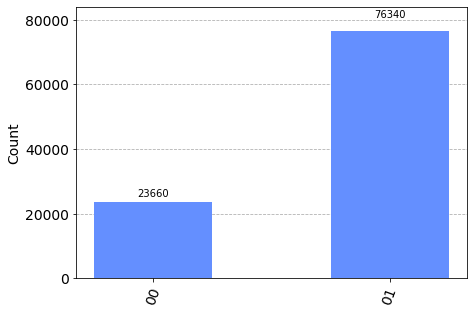

In [ ]:
shots = 100000
cirq_gates = assemble(pulse_twoone,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=shots)

sim_result = backend_sim.run(cirq_gates).result()
from qiskit.visualization import plot_histogram
pulse_counts = sim_result.get_counts()
plot_histogram(pulse_counts)

In [ ]:
from paddle_quantum.qinfo import negativity, logarithmic_negativity, partial_transpose, is_ppt
from paddle_quantum.state import bell_state
from paddle_quantum.qinfo import state_fidelity

# rho0 = bell_state(2)

cirq_gates = assemble(pulse_onetwo,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

sim_result = backend_sim.run(cirq_gates).result()

# backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2 }
# job=execute(pulse_onetwo, backend, shots=100000, meas_level=2, meas_return='avg')
# results = job.result()
vec = sim_result.get_statevector()
# print(len(vec))
rho = qi.partial_trace(vec, [2,3,4])
rho_q0 = qi.partial_trace(vec, [1,2,3,4])
print(rho_q0)

# print(rho)
print(rho.data)
print("\n Check purity if it's a pure state:", qi.purity(rho_q0))
print("\n Check Negativity=", negativity(rho.data))
# fid = state_fidelity(rho0, rho.data) ** 2
# print("Fidelity=", fid)

/usr/local/lib/python3.8/dist-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/usr/local/lib/python3.8/dist-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


NameError: ignored

## 2.2 Scan amp

In [14]:
import random
import decimal
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere

/usr/local/lib/python3.9/dist-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/usr/local/lib/python3.9/dist-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [ ]:
outputs_mix = list()   
num_sample = 800
q1_amp_list = []
q2_amp_list = []
q3_amp_list = []
q1_ang_list = []
q2_ang_list = []
q3_ang_list = []

for _ in range(num_sample):

  amp1 = float(decimal.Decimal(random.randrange(0, 100000))/100000)
  amp2 = float(decimal.Decimal(random.randrange(0, 100000))/100000)
  amp3 = float(decimal.Decimal(random.randrange(0, 100000))/100000)
  ang1 = 2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000)
  ang2 = 2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000)
  ang3 = 2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000)


  # generate new parametrized pulse
  oneqpulse_left = generate_parametric_pulse1q(backend, 0, amp1, ang1)
  oneqpulse_right = generate_parametric_pulse1q(backend, 0, amp2, ang2)
  qubits = (0,1)
  twoqpulse = generate_2q_pulse(backend, amp3, ang3)
  pulse_twoone = generate_dressed_cr_pulse(backend, oneqpulse_left, oneqpulse_right, twoqpulse, qubits)

  # set up pulse schedule
  job = execute(pulse_twoone, backend, shots=2048, meas_level=2, meas_return='avg')
  results = job.result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho = qi.partial_trace(vec, [2,3,4])

  # record data
  outputs_mix.append(rho.data)
  q1_amp_list.append(amp1)
  q2_amp_list.append(amp2)
  q3_amp_list.append(amp3)
  q1_ang_list.append(ang1)
  q2_ang_list.append(ang2)
  q3_ang_list.append(ang3)


/usr/local/lib/python3.8/dist-packages/qiskit_aer/pulse/controllers/pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


In [ ]:
float(int(random.randrange(0, 500)))

322.0

In [ ]:
outputs_duration = list()   
num_sample = 500
q0_duration_list = []


for _ in range(num_sample):

  width1 = int(random.randrange(0, 50))

  # generate new parametrized pulse
  qubits = (0,1)
  oneqpulse = generate_parametric_pulse1q(backend, 0, 0.1, 0)
  twoqpulse = generate_2q_pulse(backend, 0.1, 0, width1, 0)
  pulse_onetwo1d1c = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

  # set up pulse schedule
  cirq_gates = assemble(pulse_onetwo1d1c,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

  results = backend_sim.run(cirq_gates).result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho = qi.partial_trace(vec, [2,3,4])

  # record data
  outputs_duration.append(rho.data)
  q0_duration_list.append(width1)

In [ ]:
outputs_amp = list()   
num_sample = 5000
q0_amp_list = []

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
width = cr_pulse.parameters['width']

for _ in range(num_sample):

  amp = float(decimal.Decimal(random.randrange(0, 100000))/100000)

  # generate new parametrized pulse
  qubits = (0,1)
  oneqpulse = generate_parametric_pulse1q(backend, 0, amp, 0)
  twoqpulse = generate_2q_pulse(backend, amp, 0, width, 0)
  pulse_onetwo1d1c = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

  # set up pulse schedule
  cirq_gates = assemble(pulse_onetwo1d1c,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

  results = backend_sim.run(cirq_gates).result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho = qi.partial_trace(vec, [2,3,4])

  # record data
  outputs_amp.append(rho.data)
  q0_amp_list.append(amp)


In [ ]:
outputs_angle = list()   
num_sample = 5000
q0_angle_list = []

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
width = cr_pulse.parameters['width']

for _ in range(num_sample):

  angle = 2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000)

  # generate new parametrized pulse
  qubits = (0,1)
  oneqpulse = generate_parametric_pulse1q(backend, 0, 0.08, angle)
  twoqpulse = generate_2q_pulse(backend, 0.08, angle, width, 0)
  pulse_onetwo1d1c = generate_12q1d1c_pulse(backend, oneqpulse, twoqpulse, qubits)

  # set up pulse schedule
  cirq_gates = assemble(pulse_onetwo1d1c,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

  results = backend_sim.run(cirq_gates).result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho = qi.partial_trace(vec, [2,3,4])

  # record data
  outputs_angle.append(rho.data)
  q0_angle_list.append(width1)


In [16]:
outputs_mix = list()   
num_sample = 3000
q1_amp_list = []
q2_amp_list = []
q1_ang_list = []
q2_ang_list = []
q1_duration_list = []

for _ in range(num_sample):

  amp = [float(decimal.Decimal(random.randrange(0, 100000))/100000) for _ in range(5)]
  ang = [2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000) for _ in range(5)]
  duration = [random.randrange(256, 1024, 16)]
  # generate new parametrized pulse
  firstlayer = generate_secondlayer(backend, 2, amp, ang,duration)
  # set up pulse schedule
  cirq_gates = assemble(firstlayer,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

  results = backend_sim.run(cirq_gates).result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho = qi.partial_trace(vec, [2,3,4])

  # record data
  outputs_mix.append(rho.data)
  q1_amp_list.append(amp)
  q1_ang_list.append(ang)
  q1_duration_list.append(duration)

/usr/local/lib/python3.9/dist-packages/qiskit_aer/backends/pulse_simulator.py:254: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return super().run(schedules, validate=validate, **run_options)


Save Data

In [35]:
import pickle
file_open = open('3000samplingdressedduration.pickle','wb')
pickle.dump(q1_duration_list,file_open)
file_open.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Calculate Entanglement Capability

In [15]:
outputs_mix = list()   
num_sample = 500
ent_list = []

for _ in range(num_sample):

  amp = [float(decimal.Decimal(random.randrange(0, 100000))/100000) for _ in range(5)]
  ang = [2*np.pi*float(decimal.Decimal(random.randrange(0, 100000))/100000) for _ in range(5)]
  duration = [random.randrange(256, 1024, 16)]
  # generate new parametrized pulse
  firstlayer = generate_secondlayer(backend, 2, amp, ang,duration)
  # set up pulse schedule
  cirq_gates = assemble(firstlayer,
                    backend=backend_sim,
                    qubit_lo_freq=freq,
                    meas_level=2,
                    meas_return='avg',
                    shots=2048)

  results = backend_sim.run(cirq_gates).result()
  # Returen the density matrix of q0
  vec = results.get_statevector()
  # print(len(vec))
  rho1 = qi.partial_trace(vec, [1,2,3,4])
  rho2 = qi.partial_trace(vec, [0,2,3,4])
  p = (qi.purity(rho1) + qi.purity(rho2))/2
  # Calculate Q
  Q =2*(1-p)
  ent_list.append(Q)

/usr/local/lib/python3.9/dist-packages/qiskit_aer/backends/pulse_simulator.py:254: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return super().run(schedules, validate=validate, **run_options)


In [39]:
ent_list

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [40]:
Ent = sum(ent_list)/num_sample
print("Eantangling Capability for this PQC is: {0:.6f}".format(Ent))

Eantangling Capability for this PQC is: 1.000000


In [1]:
outputs_rxcx = np.array(outputs_rxcx)

NameError: ignored

In [ ]:
outputs_rxcx

array([<paddle_quantum.state.state.State object at 0x7f649be7d7c0>,
       <paddle_quantum.state.state.State object at 0x7f649be7d5e0>, ...,
      dtype=object)

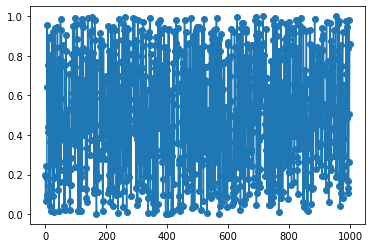

In [ ]:
import matplotlib.pyplot as plt
plt.plot(q2_amp_list,"o-")

## 2.3 Scan angle

## 2.4 Scan both parameters

In [21]:
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.qinfo import state_fidelity, partial_trace, purity
import warnings

# Haar distribution and K-L divergence

In [18]:
num_qubit = 2     # the number of qubit
num_sample = 3000   # the number of sample
outputs_rxcx = list()   # save QNN outputs
outputs_zzry = list()

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # apply Rz with a random rotating angle
    cir.rx(0)
    cir.cnot([0, 1])
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_rxcx.append(rho.numpy())

outputs_x = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Rx with random rotating angles
    cir.cz([0, 1])
    cir.ry(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_zzry.append(rho.numpy())

/usr/local/lib/python3.9/dist-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


In [37]:
from paddle_quantum.state import bell_state

In [38]:
## 2 qubit in theory Ent = (N-2)/(N+1) = 0.4
num_qubit = 2        # the number of qubit
num_sample = 500    # the number of sample
ent_list = []

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # Generate GHZ state
    cir.superposition_layer()
    cir.cnot([0, 1])
    # Get purity for each reduced density matrix
    rho = bell_state(num_qubit)
    rho1 = partial_trace(rho, 2, 2, 1)
    rho2 = partial_trace(rho, 2, 2, 2)
    p = (purity(rho1) + purity(rho2))/num_qubit
    # Calculate Q
    Q =2*(1-p)
    ent_list.append(Q.numpy()[0])

Ent = sum(ent_list)/num_sample
print("Eantangling Capability for this PQC is: {0:.6f}".format(Ent))

/usr/local/lib/python3.9/dist-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


Eantangling Capability for this PQC is: 1.000000


In [19]:
num_qubit = 2     # the number of qubit
num_sample = 3000    # the number of sample
outputs_universal2q = list()   # save QNN outputs

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # apply Rz with a random rotating angle
    cir.universal_two_qubits()
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_universal2q.append(rho.numpy())


In [ ]:
print(cir)

NotImplementedError: ignored

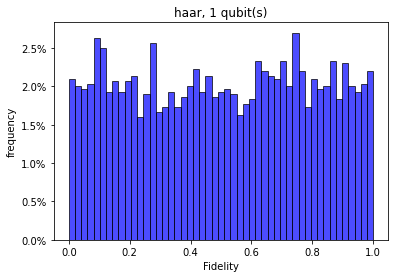

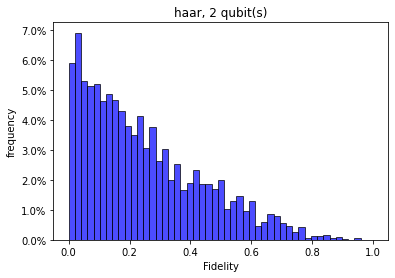

In [20]:
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

# plot histgram
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1./len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
    
# evaluate the probability distribution of F generated by a Haar random unitary
def p_F_haar(n, s, b=50, draw=False):
    f_list = list()
    # sampling
    for i in range(s):
        # sample a unitary
        u1 = haar_unitary(n)
        # the output of u1
        phi1 = u1[:,0]
        rho1 = to_state(np.outer(phi1, phi1.conj()))
        # sample a unitary
        u2 = haar_unitary(n)
        phi2 = u2[:,0]
        # the output of u2
        rho2 = to_state(np.outer(phi2, phi2.conj()))
        # compute fidality
        f_list.append(state_fidelity(rho1.numpy(), rho2.numpy())**2)

    f_list = np.array(f_list)

    # plot histgram
    if draw:
        title_str = "haar, %d qubit(s)" % num_qubit
        plot_hist(f_list, b, title_str)
    sample_distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)

    # compute a theoretical distribution
    theory_distribution = np.zeros_like(sample_distribution)
    for index in range(len(theory_distribution)):
        def p_continues(f):
            return (2 ** n - 1) * (1 - f) ** (2 ** n - 2)
        lower = 1/b*index
        upper = lower + 1/b
        theory_distribution[index], _ = integrate.quad(p_continues,lower,upper)
    return sample_distribution, theory_distribution


num_qubit = 1
p_haar_1qubit, theory_haar_1qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 2
p_haar_2qubit, theory_haar_2qubit = p_F_haar(num_qubit, num_sample, draw=True)

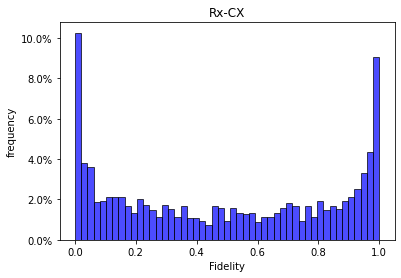

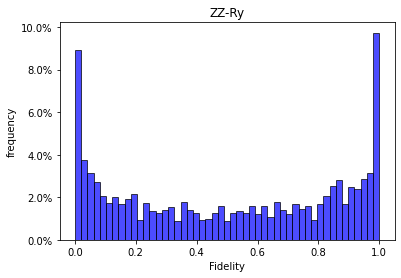

In [21]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnn(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_universal2q
    title_str = "Universal 2q circuit"
    if g == 2:
        rho_sample = outputs_mix
        title_str = "1d1c CR"
    elif g == 3:
        rho_sample = outputs_rxcx
        title_str = "Rx-CX"
    elif g == 4:
        rho_sample = outputs_zzry
        title_str = "ZZ-Ry"
    elif g == 5:
        rho_sample = outputs_duration
        title_str = "Duration"
    # elif g == 6:
    #     rho_sample = outputs_amp
    #     title_str = "Parametrized Pulse Amplitude"
    # elif g == 7:
    #     rho_sample = outputs_angle
    #     title_str = "Parametrized Pulse Angle"
    # elif g == 8:
    #     rho_sample = outputs_mix
    #     title_str = "Parametrized Pulse General"

    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution
    
    
num_qubit = 1
p_3 = p_F_qnn(num_qubit, num_sample, 3, draw=True)
p_4 = p_F_qnn(num_qubit, num_sample, 4, draw=True)
#p_pulse = p_F_qnn(num_qubit, num_sample, 2, draw=True)

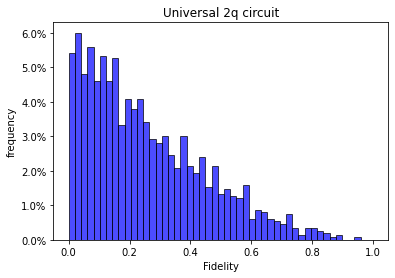

In [22]:
p_1 = p_F_qnn(num_qubit, num_sample, 1, draw=True)

In [23]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnnpulse(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_universal2q
    title_str = "Universal 2q circuit"
    if g == 2:
        rho_sample = outputs_mix
        title_str = "1d1c CR"
    elif g == 3:
        rho_sample = outputs_rxcx
        title_str = "Rx-CX"
    elif g == 4:
        rho_sample = outputs_zzry
        title_str = "ZZ-Ry"
    elif g == 5:
        rho_sample = outputs_duration
        title_str = "Duration"
    # elif g == 6:
    #     rho_sample = outputs_amp
    #     title_str = "Parametrized Pulse Amplitude"
    # elif g == 7:
    #     rho_sample = outputs_angle
    #     title_str = "Parametrized Pulse Angle"
    # elif g == 8:
    #     rho_sample = outputs_mix
    #     title_str = "Parametrized Pulse General"

    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution

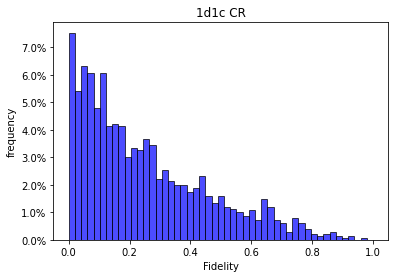

In [24]:
p_dressedpulse = p_F_qnnpulse(num_qubit, num_sample, 2, draw=True)

In [ ]:
p_pulse = p_F_qnn(num_qubit, num_sample, 2, draw=True)

AttributeError: ignored

In [25]:
from scipy.stats import entropy
# calcutale relative entropy (K-L divergence)
expr_dressedpulse = entropy(p_dressedpulse, theory_haar_2qubit)
expr_2 = entropy(p_3, theory_haar_2qubit)
expr_1 = entropy(p_1, theory_haar_2qubit)

In [26]:
expr_1

0.012470016932398902

In [27]:
expr_dressedpulse

0.021042607508218514

In [28]:
expr_2

1.350426489008652

In [29]:
from scipy.stats import entropy
# calcutale relative entropy (K-L divergence)
expr_3 = entropy(p_3, theory_haar_2qubit)
expr_4 = entropy(p_4, theory_haar_2qubit)
print(expr_3)
print(expr_4)

1.350426489008652
1.3727710592647582


In [ ]:
expr_2

1.316769876585933

In [ ]:
expr_pulse

0.1023958819778037

## 3.2 Results Summary

| operation | K-L divergence (lower=better)|
|:---------:|:----------------------------:|
|   Universal 2q Circuit (num_sample=800)  | 0.0764338315067443 |
|   Universal 2q Circuit (num_sample=2000)  | 0.028597619462714052 |
|   Universal 2q Circuit (num_sample=3000)  | 0.014532215787264118 |
|   1q + CR Pulse (num_sample=500)     |  |
|   Dressed CR Pulse (num_sample=800, runtime$\approx$1hr)    | 0.6786137036976433 |
